In [8]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

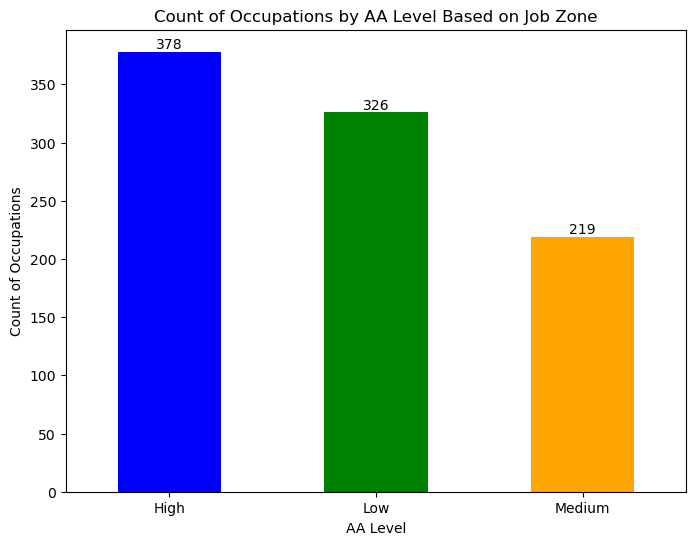

In [2]:
# Load the uploaded CSV file
file_path = 'All_Occupations.csv'
occupations_df = pd.read_csv(file_path)

# 1) Count how many occupations are on each AA level based on Job Zone
aa_level_counts = occupations_df['AA Level Based on Job Zone'].value_counts()

# Adding data labels to the bar plot for better clarity

# Visualization: Count of occupations on each AA level with data labels
plt.figure(figsize=(8,6))
ax = aa_level_counts.plot(kind='bar', color=['blue', 'green', 'orange'])

# Add labels
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

plt.title('Count of Occupations by AA Level Based on Job Zone')
plt.xlabel('AA Level')
plt.ylabel('Count of Occupations')
plt.xticks(rotation=0)
plt.show()


<Figure size 1200x800 with 0 Axes>

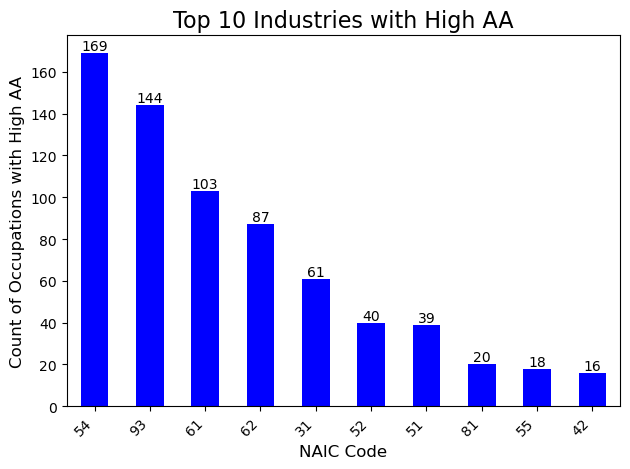

In [4]:
# Loading the dataset
file_path = 'all_industry.csv'
industry_df = pd.read_csv(file_path)

# Filtering for high AA levels
high_aa_industries = industry_df[industry_df['AA Level'] == 'High']

# Grouping by NAIC code to count the number of occupations with high AA
top_10_high_aa_naics = high_aa_industries['NAIC'].value_counts().head(10).reset_index()
top_10_high_aa_naics.columns = ['NAIC', 'Count']

# Adjusting the graph to show NAIC codes instead of industry names
plt.figure(figsize=(12, 8))  # Larger figure size
ax = top_10_high_aa_naics.plot(kind='bar', x='NAIC', y='Count', legend=False, color='blue')
plt.title('Top 10 Industries with High AA', fontsize=16)
plt.ylabel('Count of Occupations with High AA', fontsize=12)
plt.xlabel('NAIC Code', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Adding labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10)

plt.show()


<Figure size 1200x800 with 0 Axes>

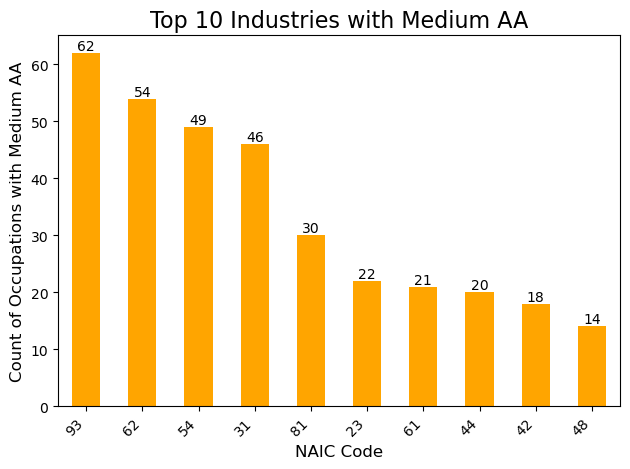

In [5]:
# Filtering for medium AA levels instead of high
medium_aa_industries = industry_df[industry_df['AA Level'] == 'Medium']

# Grouping by NAIC code and counting the number of occurrences of medium AA
top_10_medium_aa_naics = medium_aa_industries.groupby('NAIC').size().nlargest(10).reset_index(name='Count')

# Merging NAIC codes with industry names
top_10_medium_aa_naics = top_10_medium_aa_naics.merge(industry_df[['NAIC', 'Industry Name']].drop_duplicates(), on='NAIC', how='left')

# Visualization for the top 10 NAIC codes with medium AA
plt.figure(figsize=(12,8))  # Larger figure size
ax = top_10_medium_aa_naics.plot(kind='bar', x='NAIC', y='Count', legend=False, color='orange')
plt.title('Top 10 Industries with Medium AA', fontsize=16)
plt.ylabel('Count of Occupations with Medium AA', fontsize=12)
plt.xlabel('NAIC Code', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Adding labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10)

plt.show()


<Figure size 1200x800 with 0 Axes>

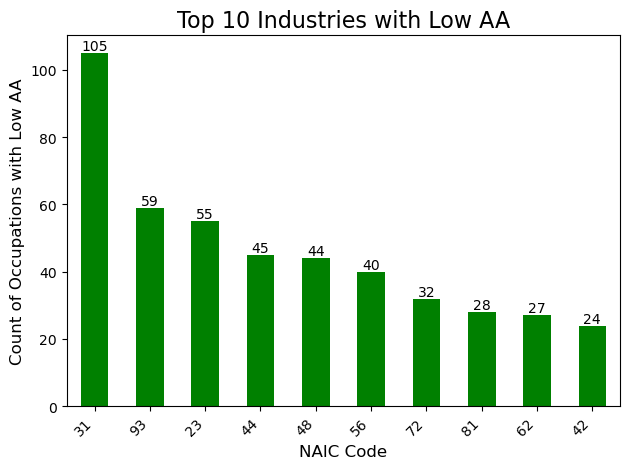

In [6]:
# Filtering for medium AA levels instead of high
low_aa_industries = industry_df[industry_df['AA Level'] == 'Low']

# Grouping by NAIC code and counting the number of occurrences of medium AA
top_10_low_aa_naics = low_aa_industries.groupby('NAIC').size().nlargest(10).reset_index(name='Count')

# Merging NAIC codes with industry names
top_10_low_aa_naics = top_10_low_aa_naics.merge(industry_df[['NAIC', 'Industry Name']].drop_duplicates(), on='NAIC', how='left')

# Visualization for the top 10 NAIC codes with medium AA
plt.figure(figsize=(12,8))  # Larger figure size
ax = top_10_low_aa_naics.plot(kind='bar', x='NAIC', y='Count', legend=False, color='green')
plt.title('Top 10 Industries with Low AA', fontsize=16)
plt.ylabel('Count of Occupations with Low AA', fontsize=12)
plt.xlabel('NAIC Code', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Adding labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10)

plt.show()

In [9]:
# Load the CSV file
file_path = 'onet_occupations.csv'
df = pd.read_csv(file_path)

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Text preprocessing function with lemmatization
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\b\d+\b', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize tokens
    return ' '.join(tokens)

# Apply preprocessing to the occupation_description column
df['cleaned_description'] = df['occupation_description'].apply(preprocess_text)

# Load pre-trained word embeddings (e.g., Google News Word2Vec)
word_vectors_path = r'C:\Users\Nina Lin\Documents\Python Scripts\DAEN690\GoogleNews-vectors-negative300.bin'

try:
    word_vectors = KeyedVectors.load_word2vec_format(word_vectors_path, binary=True)
    print("Word2Vec model loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {word_vectors_path}. Please ensure the file path is correct.")
    word_vectors = None
except PermissionError:
    print(f"Permission Error: Unable to access {word_vectors_path}. Please check file permissions.")
    word_vectors = None
except NotImplementedError as e:
    print(f"Error: {e}")
    word_vectors = None

# Proceed only if the word vectors loaded successfully
if word_vectors:
    # Define a base list of keywords related to mathematical and analytical skills
    base_keywords = [
        'analyze', 'statistical', 'data', 'calculus', 'mathematics', 'modeling',
        'problem-solving', 'research', 'quantitative', 'complex', 'abstract', 'logical'
    ]

    # Extend the base keyword list using word embeddings to find similar words
    extended_keywords = set(base_keywords)
    for word in base_keywords:
        if word in word_vectors:
            similar_words = word_vectors.most_similar(word, topn=5)  # Get top 5 similar words
            for similar_word, similarity in similar_words:
                # Only add similar words with a high similarity score
                if similarity > 0.7:
                    extended_keywords.add(similar_word)

    # Create a simple bag-of-words model to check the frequency of these keywords in descriptions
    vectorizer = CountVectorizer(vocabulary=list(extended_keywords), stop_words=stopwords.words('english'))
    keyword_matrix = vectorizer.fit_transform(df['cleaned_description'])

    # Sum keyword frequencies across each occupation description
    df_keywords = pd.DataFrame(keyword_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df['abstract_ability_score'] = df_keywords.sum(axis=1)

    # Display a sample of the DataFrame with the computed abstract ability score
    print(df[['occupation', 'occupation_description', 'abstract_ability_score']].head())

else:
    print("Word2Vec model was not loaded successfully. Skipping the keyword extraction step.")

# Save the updated DataFrame with the 'abstract_ability_score' column back to the CSV file
output_file_path = 'onet_occupations_updated.csv'
df.to_csv(output_file_path, index=False)

print(f"Updated DataFrame saved to {output_file_path}")


[nltk_data] Downloading package stopwords to C:\Users\Nina
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Nina
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Nina
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Word2Vec model loaded successfully.
                 occupation  \
0  Accountants and Auditors   
1                    Actors   
2                 Actuaries   
3            Acupuncturists   
4         Acute Care Nurses   

                              occupation_description  abstract_ability_score  
0  Examine, analyze, and interpret accounting rec...                       3  
1  Play parts in stage, television, radio, video,...                       0  
2  Analyze statistical data, such as mortality, a...                       3  
3  Diagnose, treat, and prevent disorders by stim...                       0  
4  Provide advanced nursing care for patients wit...                       0  
Updated DataFrame saved to onet_occupations_updated.csv


C:\Users\Nina Lin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [10]:
# Load the dataset
file_path = 'knowledge.csv'
knowledge_full_df = pd.read_csv(file_path)

# Assign weights to different knowledge categories based on their group and level of abstraction (1-5 scale)
knowledge_weights_grouped = {
    # Arts and Humanities
    'English Language': 2,
    'Fine Arts': 2,
    'Foreign Language': 2,
    'History and Archeology': 2,
    'Philosophy and Theology': 3,

    # Business and Management
    'Administration and Management': 3,
    'Administrative': 2,
    'Customer and Personal Service': 2,
    'Economics and Accounting': 4,
    'Personnel and Human Resources': 2,
    'Sales and Marketing': 2,

    # Communications
    'Communications and Media': 3,
    'Telecommunications': 3,
    'Education and Training': 3,

    # Engineering and Technology
    'Building and Construction': 4,
    'Computers and Electronics': 5,
    'Design': 4,
    'Engineering and Technology': 5,
    'Mechanical': 4,

    # Health Services
    'Medicine and Dentistry': 5,
    'Therapy and Counseling': 4,

    # Law and Public Safety
    'Law and Government': 4,
    'Public Safety and Security': 3,

    # Manufacturing and Production
    'Food Production': 2,
    'Production and Processing': 3,

    # Mathematics and Science
    'Biology': 4,
    'Chemistry': 5,
    'Geography': 3,
    'Mathematics': 5,
    'Physics': 5,
    'Psychology': 4,
    'Sociology and Anthropology': 3,

    # Transportation
    'Transportation': 2,
}

# Update the 'Weight' column with the new weights using the grouped weight dictionary
knowledge_full_df['Weight'] = knowledge_full_df['Knowledge'].map(knowledge_weights_grouped)

# Replace non-numeric "Importance" values with NaN and drop them
knowledge_full_df['Importance'] = pd.to_numeric(knowledge_full_df['Importance'], errors='coerce')
knowledge_full_df = knowledge_full_df.dropna(subset=['Importance'])

# Calculate the AA score as the product of Importance and Weight
knowledge_full_df['AA_Score'] = knowledge_full_df['Importance'] * knowledge_full_df['Weight']

# Calculate percentiles for AA_Score to determine thresholds for Low, Medium, and High categories
low_threshold = knowledge_full_df['AA_Score'].quantile(0.33)
high_threshold = knowledge_full_df['AA_Score'].quantile(0.67)

# Function to categorize AA levels based on the AA_Score using thresholds
def categorize_aa_score_based_on_value(aa_score):
    if aa_score <= low_threshold:
        return 'Low'
    elif aa_score <= high_threshold:
        return 'Medium'
    else:
        return 'High'

# Apply the new categorization function to determine AA Level based on AA_Score
knowledge_full_df['AA_Level'] = knowledge_full_df['AA_Score'].apply(categorize_aa_score_based_on_value)

# Export the updated dataframe to a CSV file for your review
knowledge_full_df.to_csv('knowledge_with_aa_levels_updated.csv', index=False)

# Display a sample of the final dataset
print(knowledge_full_df[['Knowledge', 'Importance', 'Weight', 'AA_Score', 'AA_Level']].head(10))


                       Knowledge  Importance  Weight  AA_Score AA_Level
0         Medicine and Dentistry        91.0       5     455.0     High
1  Customer and Personal Service        84.0       2     168.0     High
2               English Language        82.0       2     164.0     High
3         Education and Training        79.0       3     237.0     High
4                     Psychology        77.0       4     308.0     High
5         Therapy and Counseling        72.0       4     288.0     High
6                    Mathematics        60.0       5     300.0     High
7                        Biology        58.0       4     232.0     High
8     Sociology and Anthropology        52.0       3     156.0     High
9     Public Safety and Security        49.0       3     147.0     High


In [11]:
# Redefine the file paths
knowledge_with_aa_levels_path = 'knowledge_with_aa_levels_updated.csv'
industry_data_path = 'all_industry.csv'

# Load the updated knowledge dataset and the new industry dataset
knowledge_df = pd.read_csv(knowledge_with_aa_levels_path)
industry_df = pd.read_csv(industry_data_path)

# Extract SOC code from the URL in the knowledge dataset (after the last dash)
knowledge_df['SOC_Code'] = knowledge_df['URL'].str.extract(r'(\d{2}-\d{4}\.\d{2})$')

# Merge the two datasets on SOC code to bring in the industry information
merged_df = pd.merge(knowledge_df, industry_df, left_on='SOC_Code', right_on='Code', how='inner')

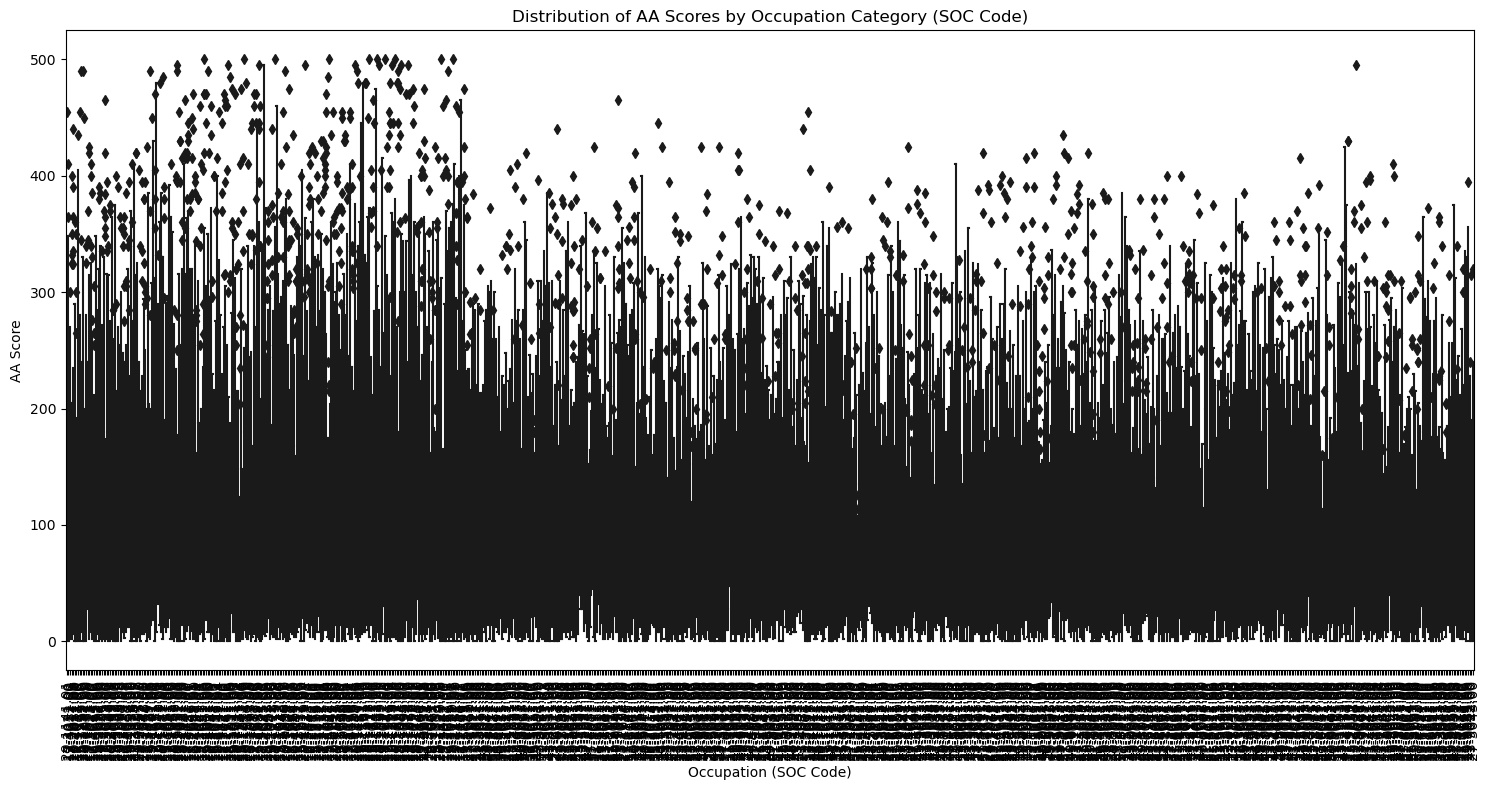

In [12]:
# Plot the AA Score distribution by Occupation (SOC Code)
plt.figure(figsize=(15, 8))
sns.boxplot(data=knowledge_df, x='SOC_Code', y='AA_Score', palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Occupation (SOC Code)')
plt.ylabel('AA Score')
plt.title('Distribution of AA Scores by Occupation Category (SOC Code)')
plt.tight_layout()

# Show the plot
plt.show()

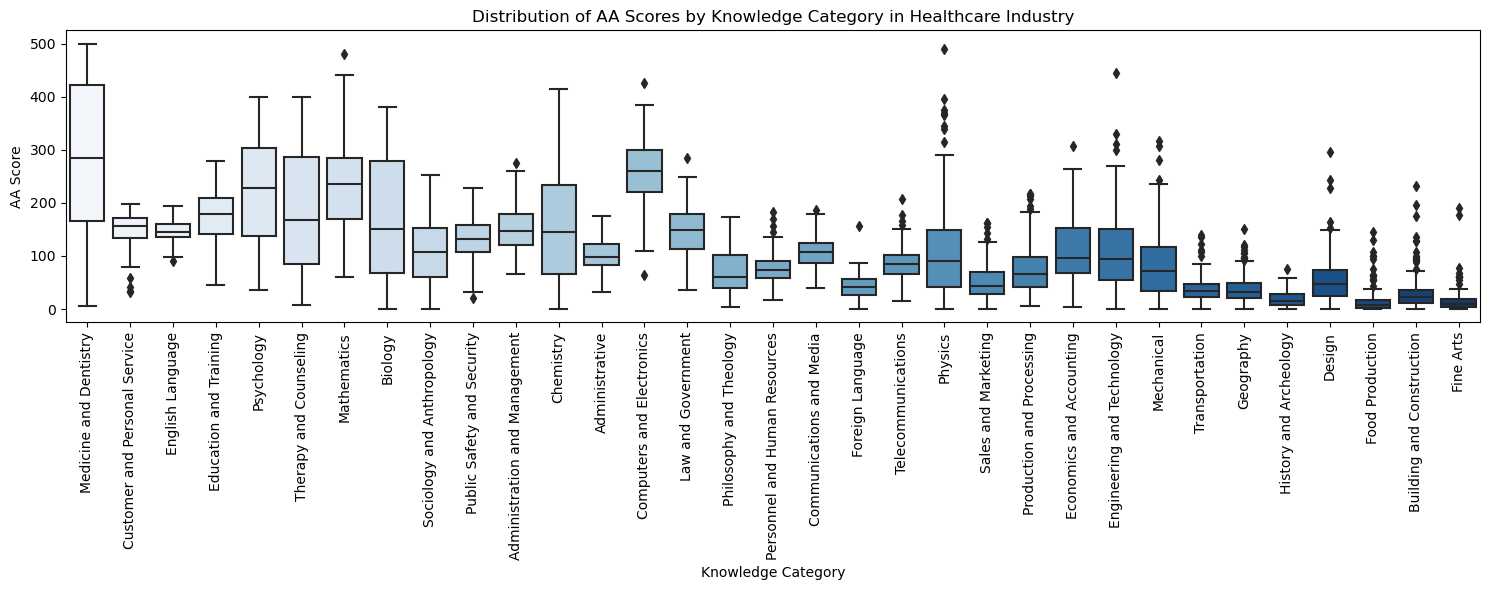

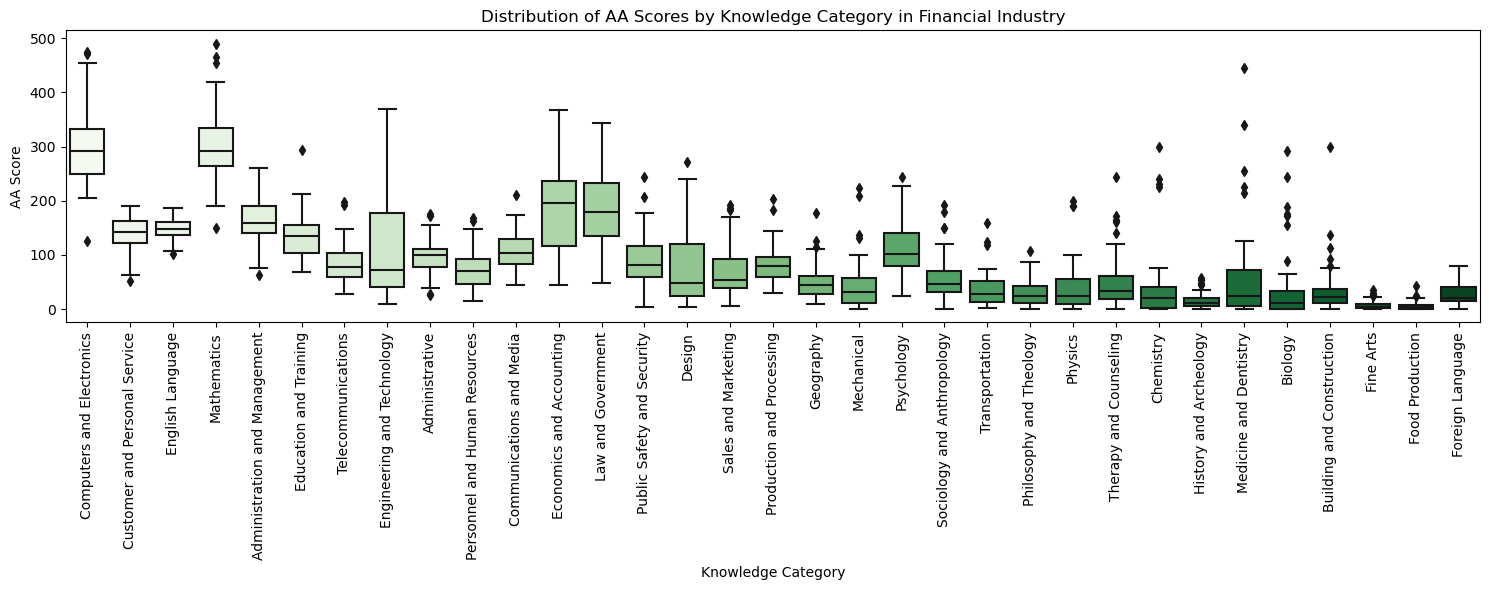

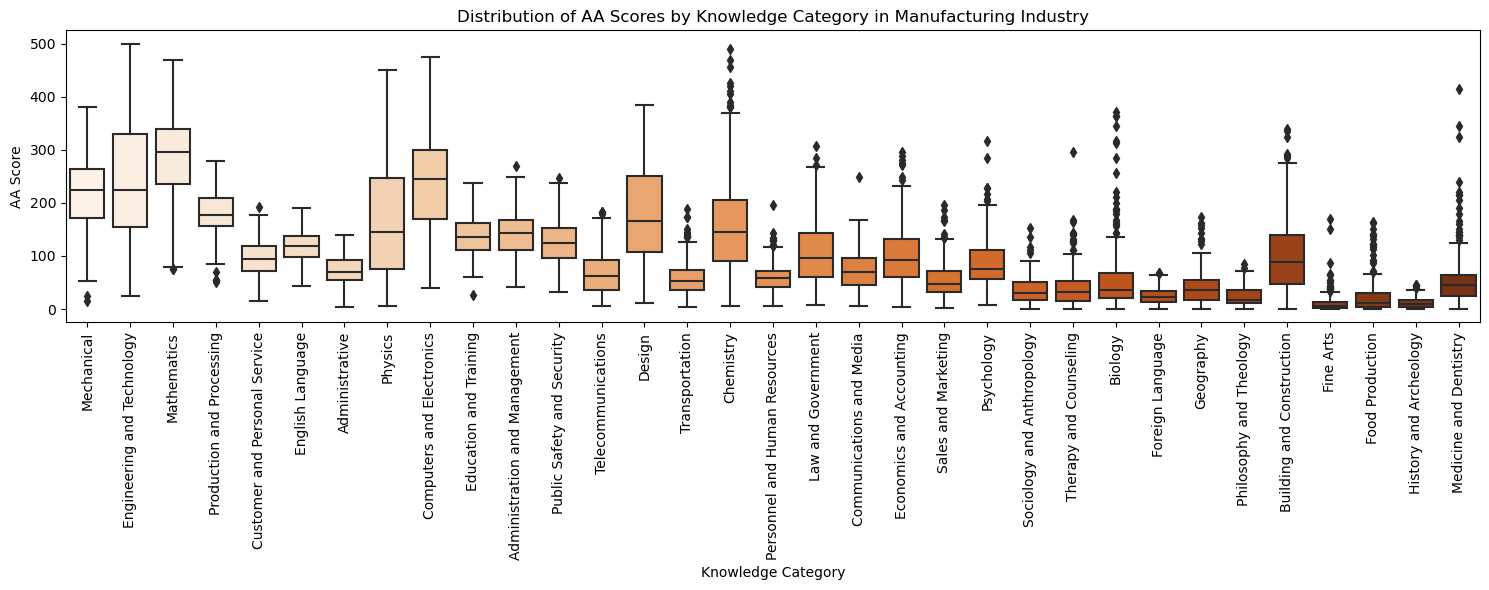

In [13]:
# Filter the merged dataframe for specific industry categories
healthcare_df = merged_df[merged_df['Industry Name'].str.contains('Health', case=False, na=False)]
financial_df = merged_df[merged_df['Industry Name'].str.contains('Finance|Financial|Banking', case=False, na=False)]
manufacture_df = merged_df[merged_df['Industry Name'].str.contains('Manufacturing|Production', case=False, na=False)]

# Plot the AA Score distribution for Healthcare Industry
plt.figure(figsize=(15, 6))
sns.boxplot(data=healthcare_df, x='Knowledge', y='AA_Score', palette='Blues')
plt.xticks(rotation=90)
plt.xlabel('Knowledge Category')
plt.ylabel('AA Score')
plt.title('Distribution of AA Scores by Knowledge Category in Healthcare Industry')
plt.tight_layout()
plt.show()

# Plot the AA Score distribution for Financial Industry
plt.figure(figsize=(15, 6))
sns.boxplot(data=financial_df, x='Knowledge', y='AA_Score', palette='Greens')
plt.xticks(rotation=90)
plt.xlabel('Knowledge Category')
plt.ylabel('AA Score')
plt.title('Distribution of AA Scores by Knowledge Category in Financial Industry')
plt.tight_layout()
plt.show()

# Plot the AA Score distribution for Manufacturing Industry
plt.figure(figsize=(15, 6))
sns.boxplot(data=manufacture_df, x='Knowledge', y='AA_Score', palette='Oranges')
plt.xticks(rotation=90)
plt.xlabel('Knowledge Category')
plt.ylabel('AA Score')
plt.title('Distribution of AA Scores by Knowledge Category in Manufacturing Industry')
plt.tight_layout()
plt.show()

In [14]:
# Aggregate AA scores by industry to calculate mean, median, and standard deviation for each industry
industry_agg_df = merged_df.groupby('Industry Name')['AA_Score'].agg(['mean', 'median', 'std']).reset_index()

# Rename the columns for better readability
industry_agg_df.columns = ['Industry Name', 'Mean_AA_Score', 'Median_AA_Score', 'Std_AA_Score']

# Display the aggregated data
industry_agg_df.head()


,Industry Name,Mean_AA_Score,Median_AA_Score,Std_AA_Score
0,Accommodation and Food Services,89.951679,75.0,65.925891
1,Administrative and Support Services,90.608049,75.0,75.146110
2,"Agriculture, Forestry, Fishing, and Hunting",104.057416,92.0,72.421291
3,"Arts, Entertainment, and Recreation",95.771044,81.0,71.513415
4,Construction,108.959300,87.0,90.431705


C:\Users\Nina Lin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nina Lin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


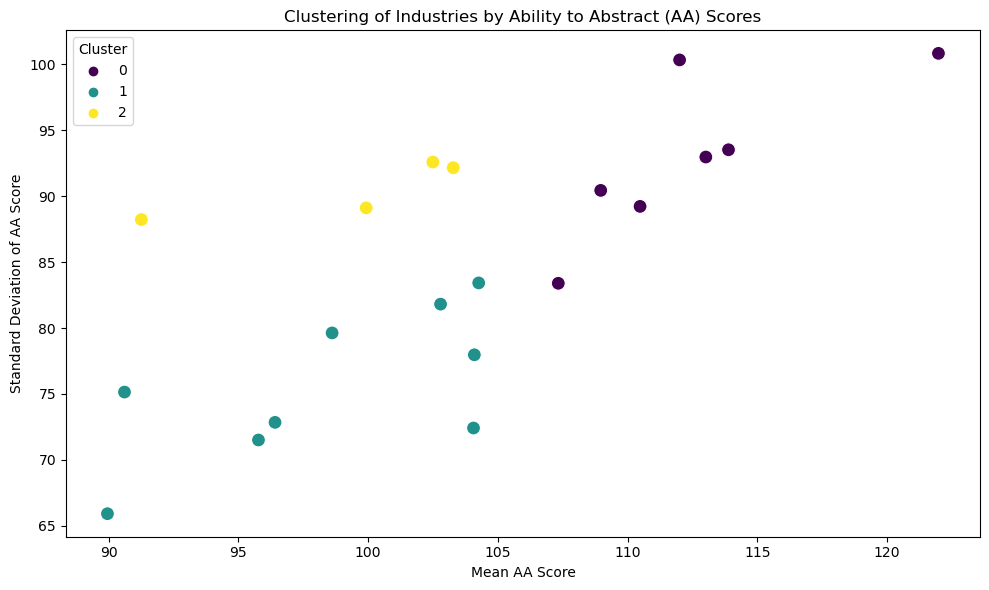

In [15]:
# Select features for clustering
features = industry_agg_df[['Mean_AA_Score', 'Median_AA_Score', 'Std_AA_Score']]

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-means clustering (choose 3 clusters for simplicity)
kmeans = KMeans(n_clusters=3, random_state=42)
industry_agg_df['Cluster'] = kmeans.fit_predict(features_scaled)

# Plot the clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(data=industry_agg_df, x='Mean_AA_Score', y='Std_AA_Score', hue='Cluster', palette='viridis', s=100)
plt.xlabel('Mean AA Score')
plt.ylabel('Standard Deviation of AA Score')
plt.title('Clustering of Industries by Ability to Abstract (AA) Scores')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
